<a href="https://colab.research.google.com/github/caroline1103/DQN_Project/blob/main/src/DQN_on_BREAKOUT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DQN ON BREAKOUT FIRST TRY**

(Does not work well)

#1. Set up



##Installations

In [ ]:
pip install pynput

In [ ]:
pip install pygame

In [ ]:
pip install gym[atari,accept-rom-license]==0.21.0

In [ ]:
pip install gym[classic_control]

In [ ]:
import os
os.kill(os.getpid(), 9)

##Packages

In [ ]:
from collections import namedtuple, deque
from itertools import count
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython import display #for the animations
plt.ion()

import gym

#for the neural network
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import huber_loss

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#2. Transitions and their storage in a replay memory


At the beggining, we want to let the computer explore freely the environment by making mistakes and seeing in what situations it gets rewarded. However, when it has had enough experiences, we also want it to start learning from what happened.

For this purpose, we store those events as transitions between two states.

In this example, we learn randomly from transitions by giving them all the same importance. However, the batches could be created differently.

Here, we train **off-policy**, because at each update we use any transition in the replay memeort, regardless of how the agent was choosing to explore the environment when the data was obtained.

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

We create a replay memory where we will store all the transitions up to a certain capacity (then we will overwrite over the oldest ones).

In [ ]:
def replay_memory(capacity = 20000):
  return deque([],maxlen = capacity)

In [ ]:
def add_to_memory(memory, transition):
  memory.append(transition[:])

We will want to get a random batch of memory to learn from later one and we'll use this function:

In [ ]:
def meomry_batch(memory, batch_size = 128):
  return random.sample(memory, batch_size)

#3. Setting up the breakout environment


**Goal :** The goal of the game is to destroy the wall at the top of the screen by hitting the ball with a paddle. You have five lifes before losing a game.

**Rewards :** You score points by destroying bricks in the wall. The reward for destroying a brick depends on the color of the brick.

**Observations:** We observe a full image of the game, by default in RGB.

**Actions:** We choose difficulty 0 for maximum simplicity. Then, we have four actions available: move left or right, do nothing and fire.





In [ ]:
env = gym.make("Breakout-v4", difficulty = 0)

env.reset(seed = 1)

print("Action Space: {}".format(env.action_space)) 
#['NOOP', 'FIRE', 'RIGHT', 'LEFT'] = [0,1, 2,3]

print("State space: {}".format(env.observation_space))
#The RGB image

print("Step output:",env.step(1)) #returns: next_state, reward, terminated, truncated , info


In [ ]:
RANDOM_SEED = 2
torch.manual_seed(RANDOM_SEED)

env = gym.make("Breakout-v4", difficulty = 0)
env.reset(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)


#4. DQN, the action-value function Q

In summary, the goal of our algorithm is to find the optimal action that the agent should take at each step. 

This is when the action value function $Q*(s,a)$ comes in. It returns the maximum expected return achievable from taking the action $a$ after observing a state $s$.

We define the action value function as below with the **Bellman equation**:

$Q*(s,a) = r + \gamma max Q*(s',a')$ ,

with $r$ the reward in we get from taking action $a$ in state $s$, $Q*(s',a')$ is the expected future return we can get from the next state and $\gamma$ is the discount factor (as we would rather be rewarded sooner than later).

But in reality, we don't know $Q*$ and we need to approximate it. To this purpose we use a neural network which we define as follows(same as implemented on [the pytorch website](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training)):

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.__conv1 = nn.Conv2d(n_observations, 64, kernel_size=1, stride=4, bias=False)
        self.__conv2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        self.__conv3 = nn.Conv2d(128, 64, kernel_size=1, stride=1, bias=False)
        self.__fc1 = nn.Linear(1280, 512)
        self.__fc2 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = x / 255.
        x = F.relu(self.__conv1(x))
        x = F.relu(self.__conv2(x))
        x = F.relu(self.__conv3(x))
        x = F.relu(self.__fc1(x.view(x.size(0), -1)))
        return self.__fc2(x)

    def init_weights(module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight, nonlinearity="relu")
            module.bias.data.fill_(0.0)
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.kaiming_normal_(module.weight, nonlinearity="relu")


#5. Selecting an action

An import step is to actually select an action for the computer to execute. From the DQN we defined above, this should be pretty easy.

However, we need to consider that at the beggining of the training, the computer doesn't know anything: it has no memories.

Furthermore, we want it to keep exploring other possibilites and avoid it taking always the same decisions which could return only a small reward (this cannot happen with carpole as the actions and reward are particularly limited but it will be the case in more complex games).

To avoid this issue, we take an $ϵ$ between 0 and 1 such that the agent takes a random action $ϵ$% of the time, and takes an action which maximes $Q*(s,a)$  the rest of the time. 

We will see later on that we define \epsilon such that it starts at one (the computer only explores new things at the beginning as it has no memories) and slowly and linearly decreases to a $\epsilon_{minimum}$ which is greater than 0. As time passes, the computer uses more and more its memory to chose its actions, but still explores a little as to possibly further improve its score.


In [ ]:
def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)



#6. Generating a plot of progress

I kept the function from the pytorch tutorial as it allows for a quick overview of the progress of the computer.

The plot duration is the number of actions the computer was able to take before losing. 
In cartpole, there is basically no delays so it's also the number of actions the computer was able to take without losing.

In [ ]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

#Defining our DQN networks

One thing we didn't mention yet is that we are going to need two networks. Reinforcement learning tends to be quite unstable and can diverge in some cases. Some reasons might be that one action can have a huge impact on the learning curve or that there exists correlations between past and present states.

We can call them the **policy network** and the **target network**.

When we want to optimize our model, we need to perform a gradient descent. In this situation, we use the policy network to estimate $Q_{predicted}$ for each actions. We want to compare those predicted values to the ones we want, let's call them $Q_{targeted}$ with a loss function (the Huber loss function)

Basically, we are going to update the policy network at every step during the gradient descent, and we will do a soft update at a rate to be determine on the target network with the policy network weights.

(Another thing we could do is to update the weights only each $x$ steps.)




In [ ]:
policy_net = DQN(n_observations, n_actions).to(device)
policy_net.apply(DQN.init_weights).to(device)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())


#8. A few parameters to define

We need to define **a few parameters** before we start training our algorithm:

* As mentionned in the DQN function, $\gamma$ is the **discount factor** so that futur reward are less meaningful than direct rewards.

* As mentionned in the select_action function, we need **epsilon** to slowly decrease at **rate $\epsilon_{decay}$** from $\epsilon_{maximum}$ to $\epsilon_{minimum}$. The higher $\epsilon_{decay}$ is the lower the decay will be when we define $\epsilon$ as we will see later on.

* We also need to define at which **rate $τ$ we upadte the weights of the target network**. 

* The **Adam optimizer** and its **learning rate** LR. This optimizer is prefered in the litterature to the classical stochastic gradient descent as it's supposed to be more efficient and particularly adapted to these types of problems.

In [ ]:
GAMMA = 0.99 # Discount factor

E_max = 0.9 # Starting epsilon
E_min = 0.05 # Ending epsilon
E_decay = 1000 # Rate of decrease

TAU = 0.005 # Rate at which we want to update the weights from the policy to the target nn

LR = 1e-4 # Learning rate of the AdamW optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)


#9. Optimizing the model

Once we have enough memory to get a random sample out of them, we start the optimization by creating a memory batch of transitions.

For all state and action, we compute their Q-function values through the policy network and then we compute the expected future rewards. We then compare the expected future rewards with the actual rewards we got from taking an action and we compute the Huber loss.

If the state is terminal, we set the reward to be 0 by default.

We then use the Huber loss in our backward propagation as to update our weights. We use the Huber loss as it is the loss function recommanded. It shoud prevent the exploding gradient problem from happening. This comes from the fact that in recurrent networks, the error gradients can accumate during the updates and become very large. It can result in unstability in the nerwork.

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = meomry_batch(memory, BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,batch.next_state)), dtype=torch.bool, device=device)

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.functional.huber_loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
# Get the number of state observations
state = env.reset()

n_observations = len(state) #for breakout 210
 
n_actions = env.action_space.n #for breakout 4



#10. Training

##Setting up a few variables before the main training loop


In [ ]:
memory = replay_memory(8000)

steps_done = 0

episode_durations = []

num_episodes = 600


criterion = nn.functional.huber_loss

##The main training loop

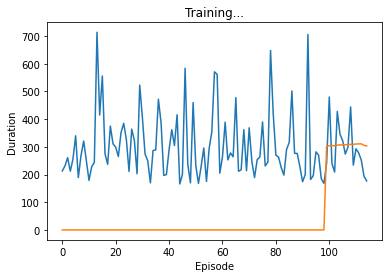

<Figure size 432x288 with 0 Axes>

In [ ]:

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) #put in select next state

    for t in count():

        eps_threshold = E_min + (E_max - E_min) * math.exp(-1. * steps_done / E_decay)
        action = select_action(state, eps_threshold)

        observation, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        add_to_memory(memory, (state, action, reward, next_state, done))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break


print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

#11. Testing and displaying the game played

## Before training

For illustration purpose, it's nice to visualize our game.

Here, we plot how the computer plays before ot was trained, meaning it's taking random actions.

We just create an array which stores RGB images of the game until it's over. The computer takes an action and updates it's current state until the game is over.

Then we can animate all those images but putting them one after another.

In [ ]:
import os
import sys
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame
pygame.init()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#this will fool the system to think it has video access

fig = plt.figure()
env = gym.make("Breakout-v4", difficulty = 0)
observation = env.reset()
ims =[]
done = False
while not done:   
    im = plt.imshow(env.render(mode = 'rgb_array'), animated=True)
    ims.append([im])
    action = env.action_space.sample()
    new_observation, reward, done, info = env.step(action)
    observation = new_observation
ims.append([plt.imshow(env.render(mode = 'rgb_array'), animated=True)])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=100)

ani.save('breakout_before_training.mp4')

plt.show()